# Teaching a quadcopter how to take-off!

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import os
import tensorflow as tf
import timeit

from   task import Task
from agents.agent import DDPG


Using TensorFlow backend.


## Useful Functions

In [3]:
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
def make_results_table(episodes):    
    return [{x : [] for x in labels} for e in range(0, episodes)]
    

## Training my Agent:

In [4]:
## TODO: Train your agent here.


#Disable tensoflow warnings...
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#num_episodes = 5000
num_episodes = 50

results = make_results_table(num_episodes)

#Execution time limit
runtime = 5.                                    

#Starts at ground, fully stopped.
init_pose = np.array([0., 0., 10., 0., 0., 0.])   # initial pose (* 10m high)
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities

#Target position
target_pos = np.array([0., 0., 20.])

task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)
agent = DDPG(task) 
agent.load_models()

rewards = []
max_reward = 0.959

complete = False
e = 0

start = timeit.timeit()

for e in range(0, num_episodes):
    state = agent.reset_episode() # start a new episode
    rewards.append([])
    while True:
        rotor_speeds = agent.act(state) 
        next_state, reward, done = task.step(rotor_speeds)
        rewards[e].append(reward / task.action_repeat)
        agent.step(rotor_speeds, reward, next_state, done)
        state = next_state
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[e][labels[ii]].append(to_write[ii])
        if done:
            mr = np.mean(rewards[e]) 
            if mr > max_reward:
                max_reward = mr
                agent.save_models_weights()
            print("\rEpisode: {:4d}, mean reward: {:7.3f} max reward: {:7.3f} last save mean reward: {:7.3f}".format(
                e + 1, mr, np.max(rewards[e]), max_reward), end="")
            break
    sys.stdout.flush()

end = timeit.timeit()
print()
print(end - start)

Instructions for updating:
Colocations handled automatically by placer.
Episode:    3, mean reward:   0.909 max reward:   0.974 last save mean reward:   0.959WARNING:tensorflow:From C:\Users\Marvi\Anaconda3\envs\quadcop\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
Episode:   50, mean reward:   0.874 max reward:   0.970 last save mean reward:   0.959
0.0010733999999949367


## Plot the Rewards and Statistics

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

8 / 8


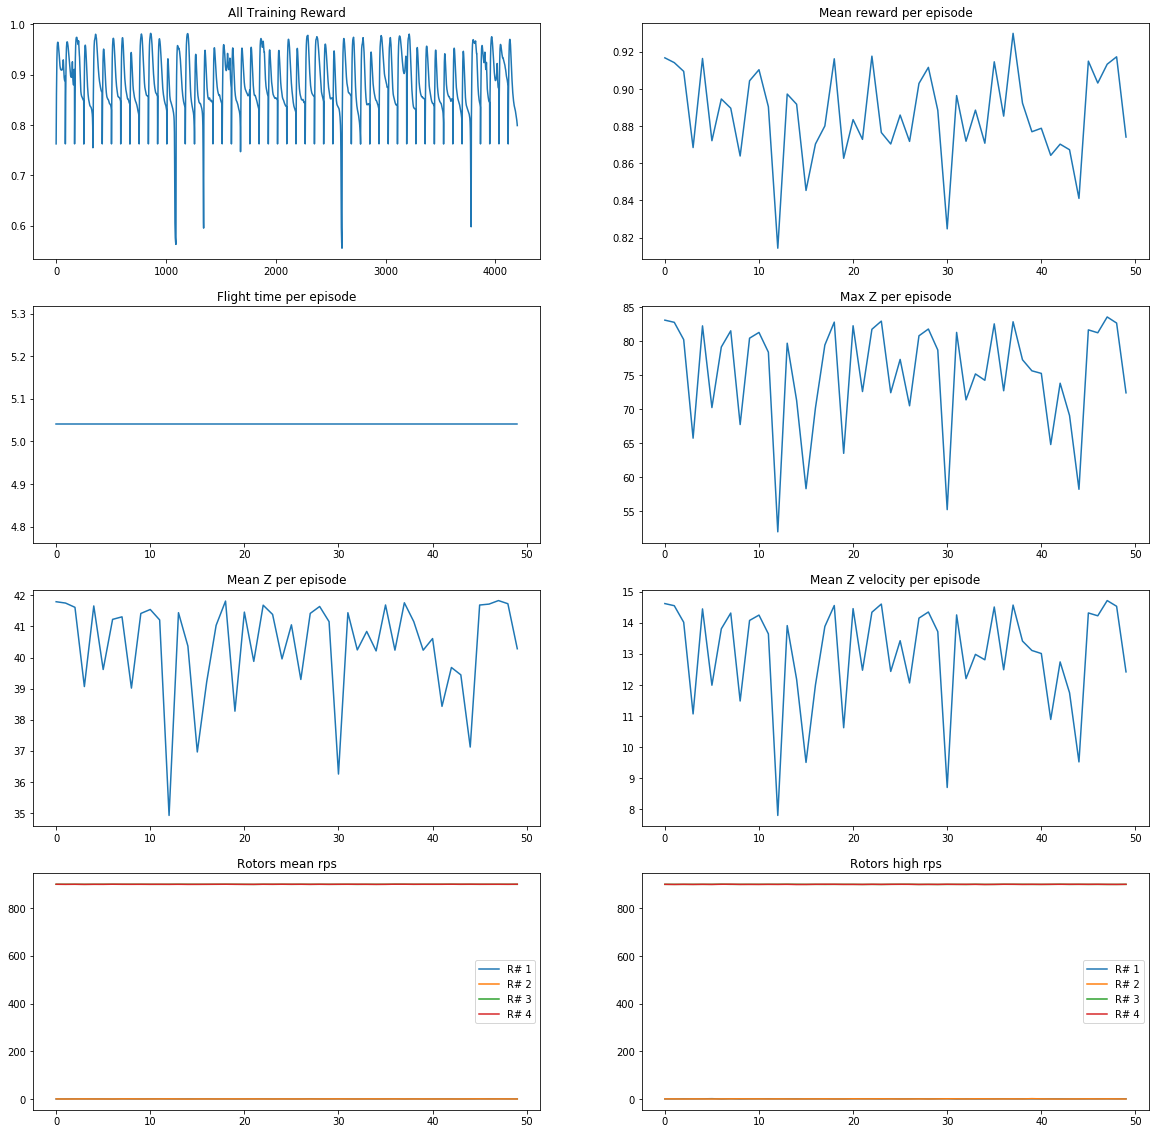

In [5]:
## TODO: Plot the rewards.
rows = 4
cols = 2
index = 0
%matplotlib inline
plt.figure(figsize=(20,5* rows))


flatten = lambda l: [item for sublist in l for item in sublist]
all_rewards = flatten(rewards)
index += 1
plt.subplot(rows,cols,index)
plt.plot(all_rewards)
plt.title("All Training Reward")

maxtime = []
meanreward = []
max_z = []
min_z = []
mea_z = []
mean_v_z = []
mean_rotor_s = [[],[],[],[]]
high_rotor_s = [[],[],[],[]]
for e in range(0, num_episodes):
    maxtime.append(max(results[e]['time']))
    max_z.append(max(results[e]['z']))
    min_z.append(min(results[e]['z']))
    mea_z.append(np.mean(results[e]['z']))
    mean_v_z.append(np.mean(results[e]['z_velocity']))
    mean_rotor_s[0].append(np.mean(results[e]['rotor_speed1']))
    mean_rotor_s[1].append(np.mean(results[e]['rotor_speed2']))
    mean_rotor_s[2].append(np.mean(results[e]['rotor_speed3']))
    mean_rotor_s[3].append(np.mean(results[e]['rotor_speed4']))
    high_rotor_s[0].append(max(results[e]['rotor_speed1']))
    high_rotor_s[1].append(max(results[e]['rotor_speed2']))
    high_rotor_s[2].append(max(results[e]['rotor_speed3']))
    high_rotor_s[3].append(max(results[e]['rotor_speed4']))    
    
    meanreward.append(np.mean(rewards[e]))
    
index += 1
plt.subplot(rows,cols,index)
plt.plot(meanreward)
plt.title("Mean reward per episode")    

index += 1    
plt.subplot(rows,cols,index)
plt.plot(maxtime)
plt.title("Flight time per episode")

index += 1
plt.subplot(rows,cols,index)
plt.plot(max_z, label='max z')
plt.title("Max Z per episode")
#plt.legend()

index += 1
plt.subplot(rows,cols,index)
plt.plot(mea_z, label='mean z')
plt.title("Mean Z per episode")

index += 1
plt.subplot(rows,cols,index)
plt.plot(mean_v_z, label='mean z velocity')
plt.title("Mean Z velocity per episode")

index += 1
plt.subplot(rows,cols,index)
for rotor in range (0,4):    
    plt.plot(mean_rotor_s[rotor], label='R# {}'.format(rotor + 1))
plt.title("Rotors mean rps".format(rotor + 1))
plt.legend()

index += 1
plt.subplot(rows,cols,index)
for rotor in range (0,4):
    plt.plot(high_rotor_s[rotor], label='R# {}'.format(rotor + 1))
plt.title("Rotors high rps".format(rotor + 1))
plt.legend()

print(index,"/",rows * cols)
_ = plt.ylim()

## Single Run ( testing the agent's take-off capacity )

In [13]:
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results_r = {x : [] for x in labels}

state = agent.reset_episode()
agent.load_models()
fm = {'x':[],'y':[],'z':[]}      
while True:
        action = agent.act(state)
        fm['x'].append(task.sim.pose[0])
        fm['y'].append(task.sim.pose[1])
        fm['z'].append(task.sim.pose[2])
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results_r[labels[ii]].append(to_write[ii])
        if done:
            break

## Flight Statistics

8 / 10


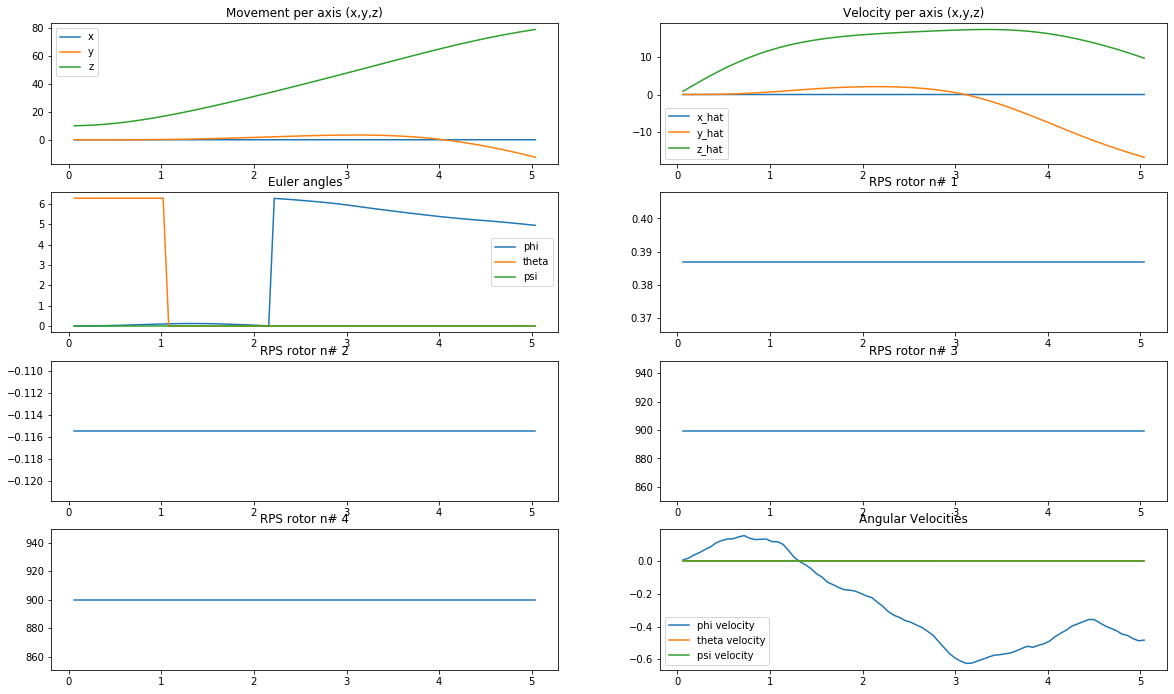

In [14]:
%matplotlib inline
%matplotlib inline

row = 5
col = 2
index = 0

plt.figure(figsize=(20,15))

index += 1
plt.subplot(row,col,index)
plt.plot(results_r['time'], results_r['x'], label='x')
plt.plot(results_r['time'], results_r['y'], label='y')
plt.plot(results_r['time'], results_r['z'], label='z')
plt.title("Movement per axis (x,y,z)")
plt.legend()


index += 1
plt.subplot(row,col,index)
plt.plot(results_r['time'], results_r['x_velocity'], label='x_hat')
plt.plot(results_r['time'], results_r['y_velocity'], label='y_hat')
plt.plot(results_r['time'], results_r['z_velocity'], label='z_hat')
plt.title("Velocity per axis (x,y,z)")
plt.legend()

index += 1
plt.subplot(row,col,index)
plt.plot(results_r['time'], results_r['phi'], label='phi')
plt.plot(results_r['time'], results_r['theta'], label='theta')
plt.plot(results_r['time'], results_r['psi'], label='psi')
plt.title("Euler angles")
plt.legend()

for r in range(0,4):
    index += 1
    plt.subplot(row,col,index)
    plt.plot(results_r['time'], results_r['rotor_speed{}'.format(r+1)])
    plt.title("RPS rotor n# {}".format(r+1))


index += 1
plt.subplot(row,col,index)
plt.plot(results_r['time'], results_r['phi_velocity'], label='phi velocity')
plt.plot(results_r['time'], results_r['theta_velocity'], label='theta velocity')
plt.plot(results_r['time'], results_r['psi_velocity'], label='psi velocity')
plt.title("Angular Velocities")
plt.legend()

print(index,"/",row * col)
_ = plt.ylim()

## 3d agent´s flight path

FigureCanvasNbAgg()

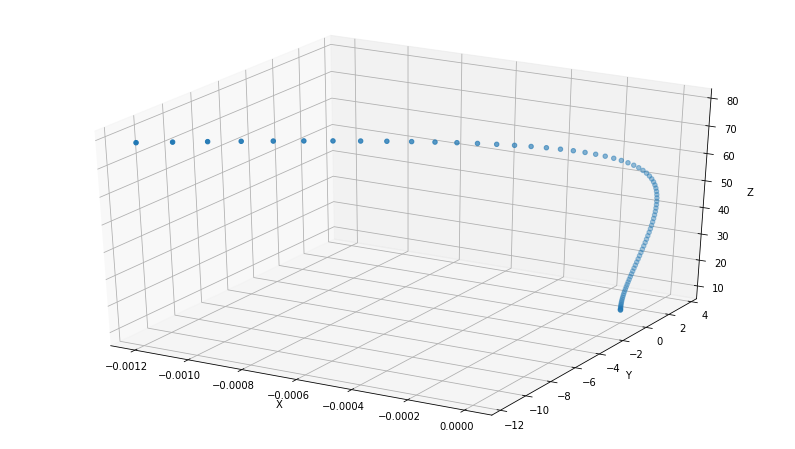

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

# Change to %matplotlib inline if dont work
%matplotlib ipympl

fig = plt.figure(figsize = (14,8))
#plt.title("3D Flight path")
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(fm['x'], fm['y'], fm['z'])
_ = plt.ylim()

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

I used a function that rewards:  
    * Ascension over Z axis  
    * Z speed  
 
and Penalizes:  
    * Huge Euler angles  
    * Huge Angular speeds  
    * Huge variatons over planex X or Y  

In [9]:
   def everything_considered(self):
        euler = self.sim.pose[3:6]
        current_pos = self.sim.pose[:3]
        start_pos = self.sim.init_pose[:3]
        speed = self.sim.v
        s_max = speed[2]  # speed in z
        s_min = speed[:2]  # speed in x, y
        angular_speed = self.sim.angular_v
        delta_position = current_pos - start_pos
        dp_max = delta_position[2]  # max this (Z)
        dp_min = delta_position[:2]  # min this (X, Y)

        euler = (abs_arctan(euler - np.pi) * 1.25).sum() / 3  # min = 0, max = 1
        angular_speed = abs_arctan_inv(angular_speed).sum() / 3  # min = 0, max = 1
        dp_min = abs_arctan_inv(dp_min).sum() / 2  # min = 0, max = 1s
        dp_max = abs_arctan(dp_max)  # min = 0, max = 1
        s_min = abs_arctan_inv(s_min).sum() / 2  # min = 0, max = 1
        s_max = np.arctan(s_max) / pi2  # min = -1 , max = 1
        
        sum = euler + angular_speed + dp_max + dp_min + s_max + s_min
        #Max possible points
        mx = 6
        #Min possible Points
        mn = -1
        delta = mx - mn
        reward = (sum + abs(mn)) / delta # Entre 0 e 1
        return reward

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

1. I used DDPG as suggested.

The final choice of the hyperparameters are:  

* Size of minibatch from experience replay memory = 256
* Tau (soft target update rate) = 0.0001
* Capacity of experience replay memory = 1000000  
Everything else was left as is.   


2. Yes the final agent uses Neural Net arch (DDPG)


3. I used the following architecture:  

Actor :

```python
states = layers.Input(shape=(self.state_size,), name='states')
net = layers.Dense(units=32 * multiplier, activation='relu')(states)
net = layers.Dense(units=64 * multiplier, activation='relu')(net)
net = layers.Dense(units=32 * multiplier, activation='relu')(net)
raw_actions = layers.Dense(units=self.action_size, activation='sigmoid', name='raw_actions')(net)
actions = layers.Lambda(lambda x: (x * self.action_range) + self.action_low,
                                name='actions')(raw_actions)
self.model = models.Model(inputs=states, outputs=actions)
action_gradients = layers.Input(shape=(self.action_size,))
```

Critic:
```python
states = layers.Input(shape=(self.state_size,), name='states')
actions = layers.Input(shape=(self.action_size,), name='actions')
net_states = layers.Dense(units=32 * multiplier, activation='relu')(states)
net_states = layers.Dense(units=64 * multiplier, activation='relu')(net_states)
net_actions = layers.Dense(units=32 * multiplier, activation='relu')(actions)
net_actions = layers.Dense(units=64 * multiplier, activation='relu')(net_actions)
net = layers.Add()([net_states, net_actions])
net = layers.Activation('relu')(net)
Q_values = layers.Dense(units=1, name='q_values')(net)
self.model = models.Model(inputs=[states, actions], outputs=Q_values)
optimizer = optimizers.Adam()
self.model.compile(optimizer=optimizer, loss='mse')
```
        

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

Learning was a very difficult process. The agent failed to converge many times until it finally did. I saved the best Weights and worked from there. 
The agent managed to get very high performance in the end, taking off very straight, but surprisingly it used only two of the four rotors for that. 

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:


    What was the hardest part of the project? 

	The hardest part was defining a good learning function, that really mapped what I wanted to achieve to the quad performance.

    Did you find anything interesting in how the quadcopter or your agent behaved?

	Yes. It managed to take off straightly, with minimum variations on X and Y axis, using only two of the four rotors. I do not know how that is possible. 